In [48]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kmapper as km
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import iqr
import hdbscan
import networkx as nx

In [49]:
df_departures = pd.read_pickle("../../calculated_distances_dep.pkl")

df_arrivals = pd.read_pickle("../../calculated_distances_arr.pkl")

print("Columns all:")
print(df_departures.columns.tolist())

Columns all:
['airportCode', 'date', 'deviation', 'delay']


In [58]:
df_dep_by_airport = df_departures.groupby(['airportCode']).agg({
    'deviation': ['mean', 'median', 'std', iqr],
    'delay': ['mean', 'median', 'std', iqr]
}).reset_index()

df_dep_by_airport.columns = ['airportCode',
                            'deviation_mean', 'deviation_median', 'deviation_std', 'deviation_iqr',
                            'delay_mean', 'delay_median', 'delay_std', 'delay_iqr']

df_arr_by_airport = df_arrivals.groupby(['airportCode']).agg({
    'deviation': ['mean', 'median', 'std', iqr],
    'delay': ['mean', 'median', 'std', iqr]
}).reset_index()


df_arr_by_airport.columns = ['airportCode',
                            'deviation_mean', 'deviation_median', 'deviation_std', 'deviation_iqr',
                            'delay_mean', 'delay_median', 'delay_std', 'delay_iqr']

df_all_by_airport = pd.merge(df_dep_by_airport, df_arr_by_airport, on=['airportCode'], suffixes=('_dep', '_arr'))



display(df_all_by_airport.head())

print(df_all_by_airport.shape)

,airportCode,deviation_mean_dep,deviation_median_dep,deviation_std_dep,deviation_iqr_dep,delay_mean_dep,delay_median_dep,delay_std_dep,delay_iqr_dep,deviation_mean_arr,deviation_median_arr,deviation_std_arr,deviation_iqr_arr,delay_mean_arr,delay_median_arr,delay_std_arr,delay_iqr_arr
0,GCFV,2344.814885,1390.821004,2560.690100,2457.702446,-0.917071,-2.966667,14.346604,14.833333,3079.005991,3783.673574,2607.658528,4983.504387,-0.404947,-1.616667,11.441832,11.400000
1,GCGM,274.946616,224.047083,223.247584,264.088464,-4.829581,-6.000000,9.376121,9.333333,679.957038,616.179451,250.805857,203.840244,-20.294278,-21.025000,8.941157,9.987500
2,GCHI,359.374056,322.307876,194.276413,222.184474,-2.742581,-3.691667,8.053626,9.133333,568.341909,479.158419,470.263760,639.448996,-0.622293,-1.083333,8.352575,10.358333
3,GCLA,801.299793,289.824771,1422.706129,334.878341,-1.787814,-2.883333,8.525683,8.600000,448.432746,145.941698,809.213556,271.185742,0.128403,-1.300000,9.094736,9.658333
4,GCLP,1572.813124,579.780411,2242.388306,2129.628499,0.384889,-0.983333,12.052679,12.900000,1582.045439,1102.756425,1577.934583,1493.780925,2.307241,0.716667,14.049667,15.791667


(45, 17)


In [51]:
df_dep_by_airport.fillna({'deviation_std': 0.0, 'delay_std': 0.0}, inplace=True)
print(df_dep_by_airport.isna().sum())

print()
df_arr_by_airport.fillna({'deviation_std': 0.0, 'delay_std': 0.0}, inplace=True)
print(df_arr_by_airport.isna().sum())


print()
df_all_by_airport.fillna({'deviation_std_dep': 0.0, 'delay_std_dep': 0.0, 'deviation_std_arr': 0.0, 'delay_std_arr': 0.0}, inplace=True)
print(df_all_by_airport.isna().sum())

airportCode         0
deviation_mean      0
deviation_median    0
deviation_std       0
deviation_iqr       0
delay_mean          0
delay_median        0
delay_std           0
delay_iqr           0
dtype: int64

airportCode         0
deviation_mean      0
deviation_median    0
deviation_std       0
deviation_iqr       0
delay_mean          0
delay_median        0
delay_std           0
delay_iqr           0
dtype: int64

airportCode             0
deviation_mean_dep      0
deviation_median_dep    0
deviation_std_dep       0
deviation_iqr_dep       0
delay_mean_dep          0
delay_median_dep        0
delay_std_dep           0
delay_iqr_dep           0
deviation_mean_arr      0
deviation_median_arr    0
deviation_std_arr       0
deviation_iqr_arr       0
delay_mean_arr          0
delay_median_arr        0
delay_std_arr           0
delay_iqr_arr           0
dtype: int64


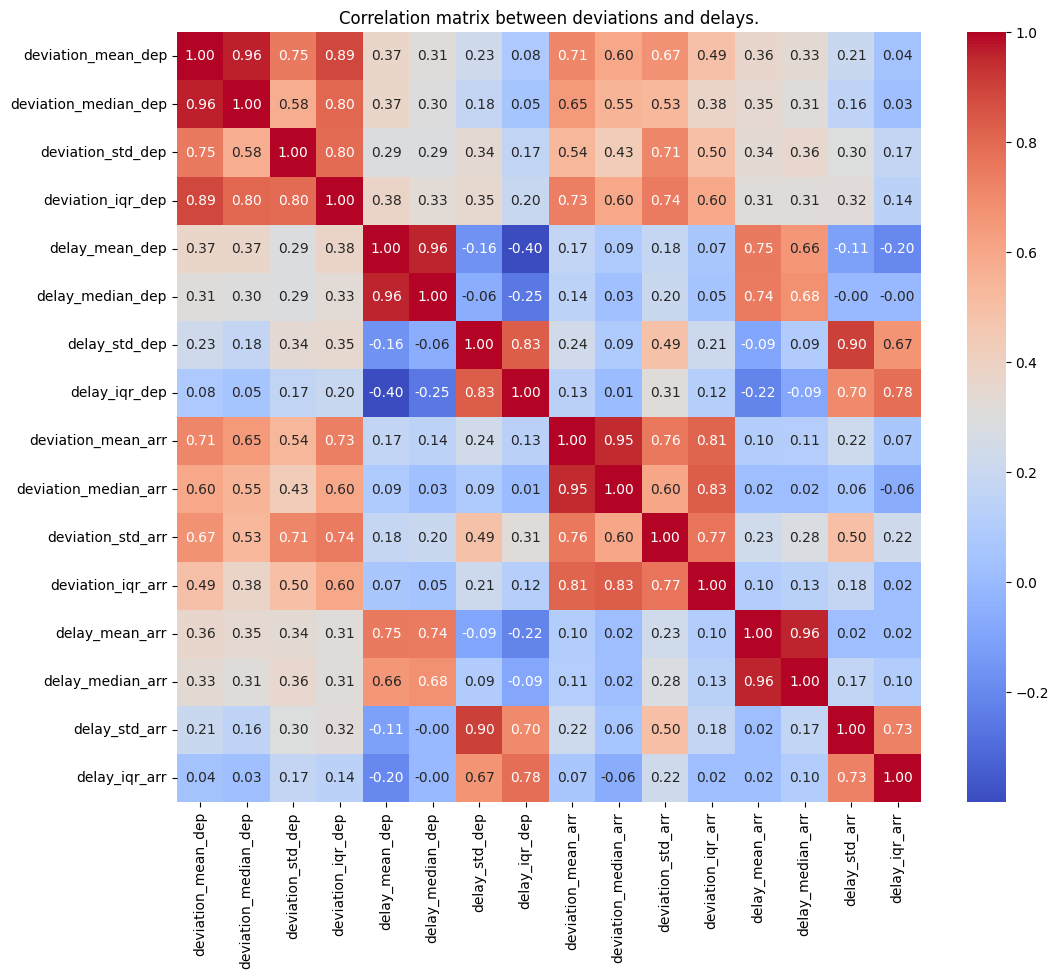

In [52]:
df_numeric = df_all_by_airport.drop(columns=['airportCode'])

corr_matrix = df_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix between deviations and delays.")
plt.show()

In [53]:
df_spanish_airports = pd.read_pickle('../../spanish_airports.pkl')

X_all = df_all_by_airport.drop(columns=['airportCode']).dropna()

print(X_all.head())
print()

scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(X_all)

custom_tooltips_all = np.array([
     f"{df_spanish_airports.loc[df_spanish_airports['ICAO'] == row['airportCode'], 'Aeropuerto'].values[0] }" for _, row in df_all_by_airport.iterrows()
])

print(X_scaled_all)

   deviation_mean_dep  deviation_median_dep  deviation_std_dep  \
0         2344.814885           1390.821004        2560.690100   
1          274.946616            224.047083         223.247584   
2          359.374056            322.307876         194.276413   
3          801.299793            289.824771        1422.706129   
4         1572.813124            579.780411        2242.388306   

   deviation_iqr_dep  delay_mean_dep  delay_median_dep  delay_std_dep  \
0        2457.702446       -0.917071         -2.966667      14.346604   
1         264.088464       -4.829581         -6.000000       9.376121   
2         222.184474       -2.742581         -3.691667       8.053626   
3         334.878341       -1.787814         -2.883333       8.525683   
4        2129.628499        0.384889         -0.983333      12.052679   

   delay_iqr_dep  deviation_mean_arr  deviation_median_arr  deviation_std_arr  \
0      14.833333         3079.005991           3783.673574        2607.658528   
1 

In [54]:
def graph_stats(graph):
    G = nx.Graph()
    for node_id in graph['nodes'].keys():
        members = graph['nodes'][node_id]
        nombres_miembros = [custom_tooltips_all[i] for i in members]
        G.add_node(node_id, members=nombres_miembros)
    
    for source, targets in graph['links'].items():
        for target in targets:
            G.add_edge(source, target)

    num_nodos = len(graph['nodes'])
    num_enlaces = len(graph['links'])
    densidad = (2 * num_enlaces) / (num_nodos * (num_nodos - 1)) if num_nodos > 1 else 0
    grados = dict(G.degree()).values()
    grado_medio = sum(grados) / len(grados) if len(grados) > 0 else 0
    grado_max = max(grados) if grados else 0
    grado_min = min(grados) if grados else 0
    num_componentes = nx.number_connected_components(G)
    diametro = nx.diameter(G) if nx.is_connected(G) else max(nx.diameter(G.subgraph(c)) for c in nx.connected_components(G))
    coef_agrupamiento = nx.average_clustering(G) if len(G) > 1 else 0

    centralidad_grado = nx.degree_centrality(G)
    centralidad_betweenness = nx.betweenness_centrality(G)

    print("Número de nodos:", num_nodos)
    print("Número de enlaces:", num_enlaces)
    print("Densidad del grafo:", densidad)
    print("Grados:", grados)
    print("Grado medio de los nodos:", grado_medio)
    print("Grado máximo:", grado_max)
    print("Grado mínimo:", grado_min)
    print("Número de componentes conectados:", num_componentes)
    print("Diámetro del grafo:", diametro)
    print("Coeficiente medio de agrupamiento:", coef_agrupamiento)
    print("Centralidad grado:", centralidad_grado)
    print("Centralidad betweeness:", centralidad_betweenness)
    print()
    print("-" * 30)

    for node_id, data in G.nodes(data=True):
        if(data and data['members']):    
            members = data['members']
            cluster_size = len(members)
            print(f"Clúster: {node_id}")
            print(f" - Número de miembros: {cluster_size}")
            print(f" - Miembros: {[str(member) for member in members]}")
            print("-" * 30)
            
    from collections import defaultdict

    apariciones_miembro = defaultdict(int)

    for _, data in G.nodes(data=True):
        if data and 'members' in data:
            for miembro in data['members']:
                apariciones_miembro[miembro] += 1

    print("\nNúmero de nodos en los que aparece cada miembro:")
    for miembro, conteo in apariciones_miembro.items():
        if conteo > 1:
            print(f" - {miembro}: {conteo} nodos")   
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, font_size=12, font_weight='bold')
    
    plt.show()

Varianza explicada por componente: [0.41185983 0.23507974 0.16159705]

Número de nodos: 20
Número de enlaces: 6
Densidad del grafo: 0.031578947368421054
Grados: dict_values([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 2, 0, 2, 2, 0, 2, 0, 1, 0])
Grado medio de los nodos: 0.6
Grado máximo: 2
Grado mínimo: 0
Número de componentes conectados: 14
Diámetro del grafo: 5
Coeficiente medio de agrupamiento: 0.0
Centralidad grado: {'cube0_cluster0': 0.0, 'cube1_cluster0': 0.0, 'cube2_cluster0': 0.0, 'cube3_cluster0': 0.0, 'cube4_cluster0': 0.0, 'cube4_cluster1': 0.0, 'cube4_cluster2': 0.05263157894736842, 'cube4_cluster3': 0.0, 'cube5_cluster0': 0.05263157894736842, 'cube5_cluster1': 0.05263157894736842, 'cube5_cluster2': 0.0, 'cube6_cluster0': 0.10526315789473684, 'cube7_cluster0': 0.0, 'cube7_cluster1': 0.10526315789473684, 'cube8_cluster0': 0.10526315789473684, 'cube9_cluster0': 0.0, 'cube9_cluster1': 0.10526315789473684, 'cube10_cluster0': 0.0, 'cube10_cluster1': 0.05263157894736842, 'cube11_cluster0':

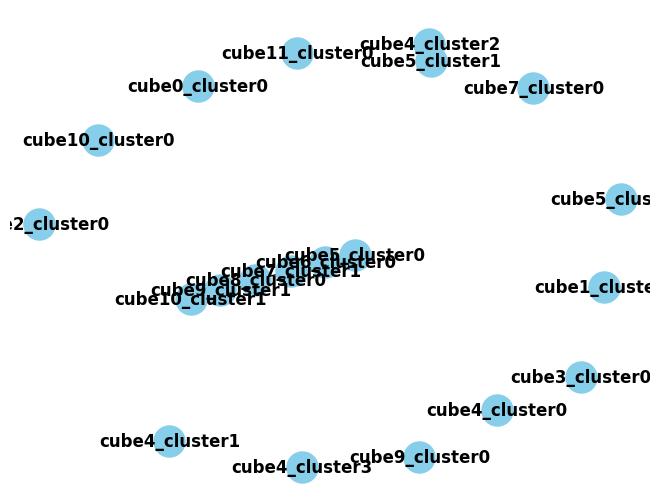

In [55]:
mapper = km.KeplerMapper()

pca = PCA(n_components=3)
filter_values_all = pca.fit_transform(X_scaled_all)
print("Varianza explicada por componente:", pca.explained_variance_ratio_)
print()

pca = PCA(n_components=1)

projection_all = pca.fit_transform(X_scaled_all)
 
graph_all = mapper.map(projection_all,
                       filter_values_all, 
                    clusterer=DBSCAN(eps=2.5, min_samples=1),
                    cover=km.Cover(n_cubes=12, perc_overlap=0.25)
)

color_values_all = X_scaled_all[:, :16]
color_function_name_all = X_all.columns[:16]

mapper.visualize(graph_all, 
                 path_html="mapper_output_all.html", 
                 custom_tooltips=custom_tooltips_all,
                 color_values=color_values_all,
                 color_function_name=color_function_name_all,
                 node_color_function=["mean", "std"])

graph_stats(graph_all)

c:\Users\Raúl\Documents\MASTER\TFM\env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Raúl\Documents\MASTER\TFM\env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Raúl\Documents\MASTER\TFM\env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Raúl\Documents\MASTER\TFM\env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Raúl\Documents\MASTER\TFM\env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_

Número de nodos: 11
Número de enlaces: 4
Densidad del grafo: 0.07272727272727272
Grados: dict_values([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])
Grado medio de los nodos: 0.7272727272727273
Grado máximo: 1
Grado mínimo: 0
Número de componentes conectados: 7
Diámetro del grafo: 1
Coeficiente medio de agrupamiento: 0.0
Centralidad grado: {'cube3_cluster0': 0.0, 'cube3_cluster1': 0.0, 'cube3_cluster2': 0.0, 'cube3_cluster3': 0.1, 'cube3_cluster4': 0.1, 'cube4_cluster0': 0.1, 'cube4_cluster1': 0.1, 'cube4_cluster2': 0.1, 'cube4_cluster3': 0.1, 'cube5_cluster0': 0.1, 'cube5_cluster1': 0.1}
Centralidad betweeness: {'cube3_cluster0': 0.0, 'cube3_cluster1': 0.0, 'cube3_cluster2': 0.0, 'cube3_cluster3': 0.0, 'cube3_cluster4': 0.0, 'cube4_cluster0': 0.0, 'cube4_cluster1': 0.0, 'cube4_cluster2': 0.0, 'cube4_cluster3': 0.0, 'cube5_cluster0': 0.0, 'cube5_cluster1': 0.0}

------------------------------
Clúster: cube3_cluster0
 - Número de miembros: 2
 - Miembros: ['Burgos – Villafría/Gamonal', 'Badajoz – Tal

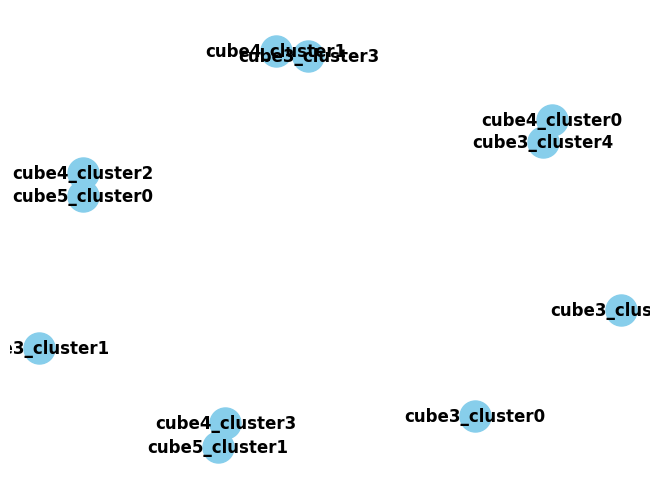

In [56]:
clusterer_all_ = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1)

graph_all_ = mapper.map(projection_all,
                         filter_values_all,
                         clusterer=clusterer_all_,
                         cover=km.Cover(n_cubes=7, perc_overlap=0.25)
)

mapper.visualize(graph_all_, 
                 path_html="mapper_output_all_.html",
                 custom_tooltips=custom_tooltips_all,
                 color_values=color_values_all,
                 color_function_name=color_function_name_all,
                 node_color_function=["mean", "std"])

graph_stats(graph_all_)

In [57]:
def get_airports_from_graph(graph, nodes=None):
    airports = set()
    if nodes is not None:
        for node_id in graph['nodes'].keys():
            members = graph['nodes'][node_id]
            if len(members) >= nodes:
                nombres_miembros = [custom_tooltips_all[i] for i in members]
                airports.update(nombres_miembros)
    else:
        for node_id in graph['nodes'].keys():
            members = graph['nodes'][node_id]
            nombres_miembros = [custom_tooltips_all[i] for i in members]
            airports.update(nombres_miembros)
        
    return airports

airports_DBSCAN = get_airports_from_graph(graph_all, 7)

airports_HDBSCAN = get_airports_from_graph(graph_all_)

airports_in_both = airports_DBSCAN & airports_HDBSCAN

print(f"Porcentaje de aeropuertos de DBSCAN {len(airports_in_both) / len(airports_DBSCAN) * 100}")
print(f"Porcentaje de aeropuertos de HDBSCAN {len(airports_in_both) / len(airports_HDBSCAN) * 100}")


Porcentaje de aeropuertos de DBSCAN 76.66666666666667
Porcentaje de aeropuertos de HDBSCAN 100.0
